## Absenteeism at Work Prediction

### Import required libraries

In [43]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import TruncatedSVD


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
df = pd.read_csv("C:/Users/dell/OneDrive/Desktop/Prithivi/Final project/MFGEmployees4.csv")

# Display first 5 rows
df.head()

,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
0,1,Gutierrez,Molly,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,36.577306,Stores
1,2,Hardwick,Stephen,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,30.165072,Stores
2,3,Delgado,Chester,M,Richmond,Baker,Bakery,Richmond,Stores,48.822047,4.389973,83.807798,Stores
3,4,Simon,Irene,F,Victoria,Baker,Bakery,Victoria,Stores,44.599357,3.081736,70.020165,Stores
4,5,Delvalle,Edward,M,New Westminster,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,0.000000,Stores


In [4]:
# Shape of dataset
df.shape

(8336, 13)

In [5]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8336 entries, 0 to 8335
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EmployeeNumber  8336 non-null   int64  
 1   Surname         8336 non-null   object 
 2   GivenName       8336 non-null   object 
 3   Gender          8336 non-null   object 
 4   City            8336 non-null   object 
 5   JobTitle        8336 non-null   object 
 6   DepartmentName  8336 non-null   object 
 7   StoreLocation   8336 non-null   object 
 8   Division        8336 non-null   object 
 9   Age             8336 non-null   float64
 10  LengthService   8336 non-null   float64
 11  AbsentHours     8336 non-null   float64
 12  BusinessUnit    8336 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 846.8+ KB


In [6]:
# Statistical summary
df.describe()

,EmployeeNumber,Age,LengthService,AbsentHours
count,8336.000000,8336.000000,8336.000000,8336.000000
mean,4168.500000,42.007086,4.782910,61.283978
std,2406.540255,9.939798,2.462990,49.038365
min,1.000000,3.504743,0.012098,0.000000
25%,2084.750000,35.298748,3.575892,19.127590
50%,4168.500000,42.114924,4.600248,56.005808
75%,6252.250000,48.666943,5.623922,94.284692
max,8336.000000,77.938003,43.735239,272.530123


In [7]:
# Missing values
df.isnull().sum()

EmployeeNumber    0
Surname           0
GivenName         0
Gender            0
City              0
JobTitle          0
DepartmentName    0
StoreLocation     0
Division          0
Age               0
LengthService     0
AbsentHours       0
BusinessUnit      0
dtype: int64

In [8]:
df.columns

Index(['EmployeeNumber', 'Surname', 'GivenName', 'Gender', 'City', 'JobTitle',
       'DepartmentName', 'StoreLocation', 'Division', 'Age', 'LengthService',
       'AbsentHours', 'BusinessUnit'],
      dtype='object')

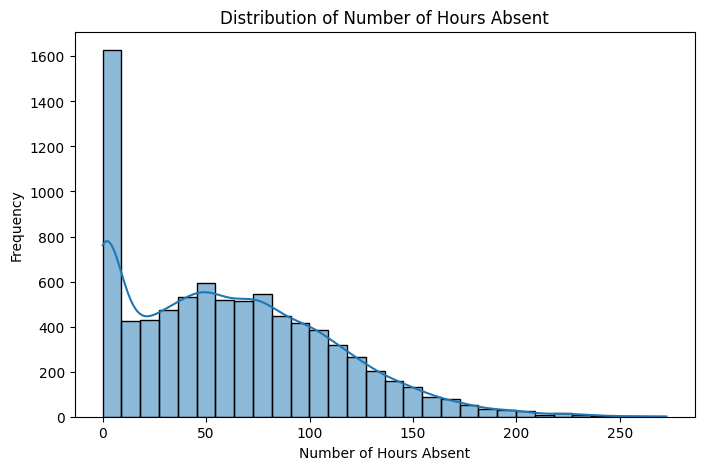

In [12]:
#Figure 1: Distribution of Number of Hours Absent

plt.figure(figsize=(8,5))
sns.histplot(df['AbsentHours'], bins=30, kde=True)
plt.title("Distribution of Number of Hours Absent")
plt.xlabel("Number of Hours Absent")
plt.ylabel("Frequency")
plt.show()


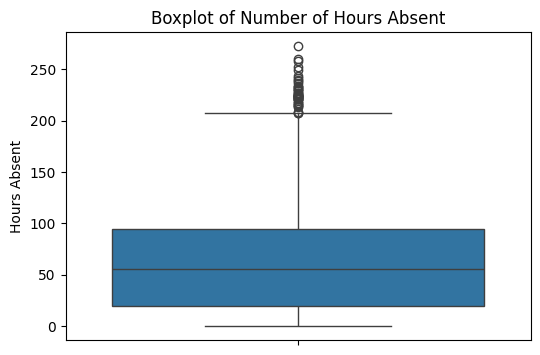

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df['AbsentHours'])
plt.title("Boxplot of Number of Hours Absent")
plt.ylabel("Hours Absent")
plt.show()


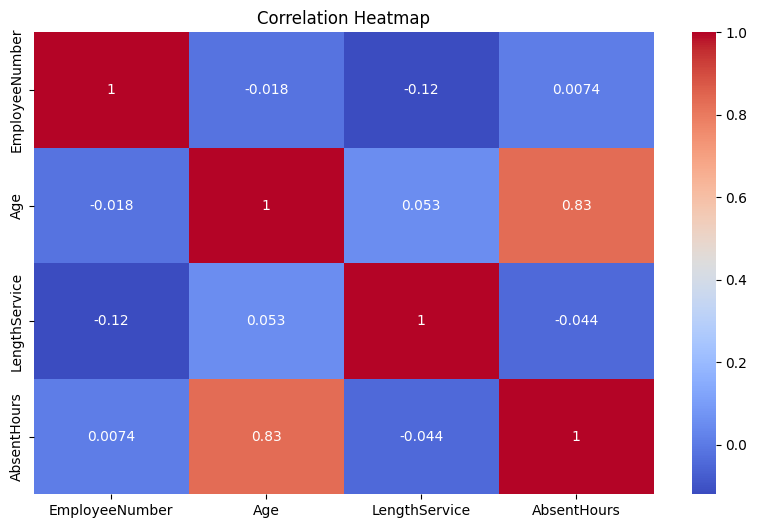

In [14]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


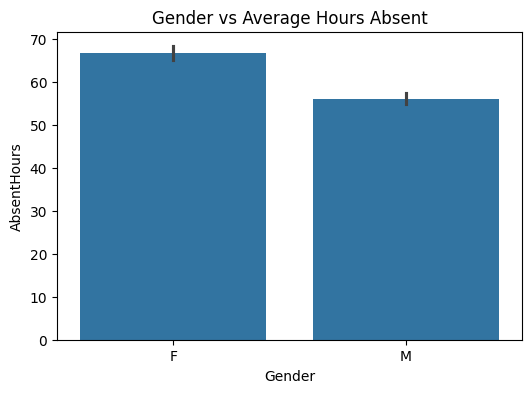

In [16]:
plt.figure(figsize=(6,4))
sns.barplot(x='Gender', y='AbsentHours', data=df)
plt.title("Gender vs Average Hours Absent")
plt.show()

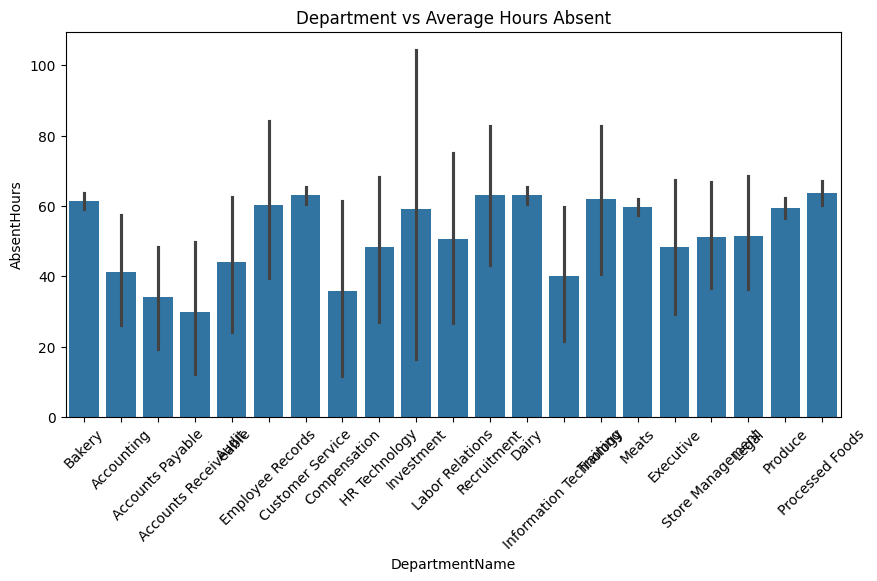

In [18]:
plt.figure(figsize=(10,5))
sns.barplot(x='DepartmentName', y='AbsentHours', data=df)
plt.xticks(rotation=45)
plt.title("Department vs Average Hours Absent")
plt.show()


#### Data Preprocessing & Feature Engineering

In [19]:
# Drop identifier and name columns
df_model = df.drop(columns=['EmployeeNumber', 'Surname', 'GivenName'])

df_model.head()


,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
0,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,36.577306,Stores
1,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,30.165072,Stores
2,M,Richmond,Baker,Bakery,Richmond,Stores,48.822047,4.389973,83.807798,Stores
3,F,Victoria,Baker,Bakery,Victoria,Stores,44.599357,3.081736,70.020165,Stores
4,M,New Westminster,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,0.000000,Stores


In [20]:
# Features and target
X = df_model.drop(columns=['AbsentHours'])
y = df_model['AbsentHours']

In [21]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

categorical_cols, numerical_cols


(Index(['Gender', 'City', 'JobTitle', 'DepartmentName', 'StoreLocation',
        'Division', 'BusinessUnit'],
       dtype='object'),
 Index(['Age', 'LengthService'], dtype='object'))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)   


#### MODEL 1 – Multiple Linear Regression (MLR)

In [24]:
mlr_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]
)


In [25]:
# Train the model
mlr_model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [26]:
# Predicitons
y_pred_mlr = mlr_model.predict(X_test)


In [27]:
# Model Evaluation
mse_mlr = mean_squared_error(y_test, y_pred_mlr)
rmse_mlr = np.sqrt(mse_mlr)
r2_mlr = r2_score(y_test, y_pred_mlr)

mse_mlr, rmse_mlr, r2_mlr

(777.669031851136, np.float64(27.88671783934309), 0.6573611372544579)

#### MODEL 2 – Random Forest Regressor (RFR)

In [28]:
# Random forest Pipeline
rfr_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]
)


In [29]:
# Training the Model
rfr_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:
# Predictions
y_pred_rfr = rfr_model.predict(X_test)

In [31]:
# Model Evaluation
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
rmse_rfr = np.sqrt(mse_rfr)
r2_rfr = r2_score(y_test, y_pred_rfr)

mse_rfr, rmse_rfr, r2_rfr

(668.7457288424472, np.float64(25.860118500162507), 0.705352448648904)

In [32]:
# Extract feature names after preprocessing
feature_names_num = numerical_cols
feature_names_cat = rfr_model.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_cols)

feature_names = np.concatenate([feature_names_num, feature_names_cat])

# Get feature importances
importances = rfr_model.named_steps['regressor'].feature_importances_

# Create importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(10)


,Feature,Importance
0,Age,0.784555
1,LengthService,0.063864
2,Gender_F,0.017103
3,Gender_M,0.014250
226,City_Vancouver,0.003174
346,StoreLocation_Vancouver,0.002899
230,City_Victoria,0.002569
256,JobTitle_Cashier,0.002422
279,JobTitle_Meat Cutter,0.002374
297,DepartmentName_Customer Service,0.002321


#### MODEL 3 – Multiple Linear Regression with PCA (TruncatedSVD)

In [38]:
preprocessor_pca = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

In [44]:
# Build MLR + PCA Pipeline
mlr_pca_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),   # original sparse preprocessor
        ('svd', TruncatedSVD(n_components=100, random_state=42)),
        ('regressor', LinearRegression())
    ]
)

In [45]:
# Train
mlr_pca_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('svd', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [46]:
# Predictions
y_pred_mlr_pca = mlr_pca_model.predict(X_test)

In [47]:
# Model Evaluation
mse_mlr_pca = mean_squared_error(y_test, y_pred_mlr_pca)
rmse_mlr_pca = np.sqrt(mse_mlr_pca)
r2_mlr_pca = r2_score(y_test, y_pred_mlr_pca)

mse_mlr_pca, rmse_mlr_pca, r2_mlr_pca

(683.4934863729774, np.float64(26.14370835158963), 0.6988546267460831)

#### MODEL-4 — Random Forest Regressor with PCA (TruncatedSVD)

In [48]:
# Build RFR + PCA Pipeline
rfr_pca_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),   # sparse output
        ('svd', TruncatedSVD(n_components=100, random_state=42)),
        ('regressor', RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

In [49]:
# train the model
rfr_pca_model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('svd', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [50]:
# Predictions
y_pred_rfr_pca = rfr_pca_model.predict(X_test)

In [51]:
# Model Evaluation
mse_rfr_pca = mean_squared_error(y_test, y_pred_rfr_pca)
rmse_rfr_pca = np.sqrt(mse_rfr_pca)
r2_rfr_pca = r2_score(y_test, y_pred_rfr_pca)

mse_rfr_pca, rmse_rfr_pca, r2_rfr_pca

(680.9502390336085, np.float64(26.095023261794736), 0.6999751746145866)